# Use Majority Vote to stabilize k-means clustering

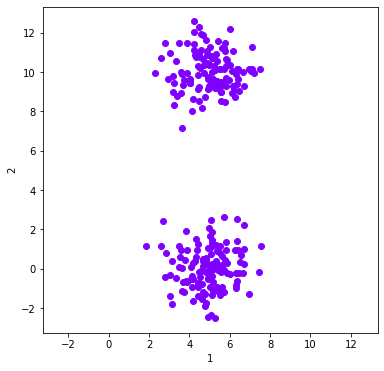

In [1]:
#Reproduce Ana Fred's Majority voting solution to stabilizing KMeans clustering using OpenEnsembles
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import datasets
import numpy as np
import openensembles as oe



#Set up a dataobject of samples from two Guassians 
n_samples = 250
np.random.seed(8)
#centers = [(0,0), (3, 6.32)] #Change distance between centers to make the problem easier/harder
centers = [(5,0), (5, 10)]
x, y = datasets.make_blobs(n_samples=n_samples,centers= centers,cluster_std=1)

df = pd.DataFrame(x) #put the dataset into a dataframe

dataObj = oe.data(df, [1,2]) #instantiate the oe data object
dataObj.plot_data('parent') # Plot this data - now referenced as 'parent'
ymin, ymax = plt.ylim() #set the limits of x to y, so it's clear that these are spherical classes
plt.xlim(ymin, ymax)
plt.show()

### Example of calculating and plotting a single clustering solution

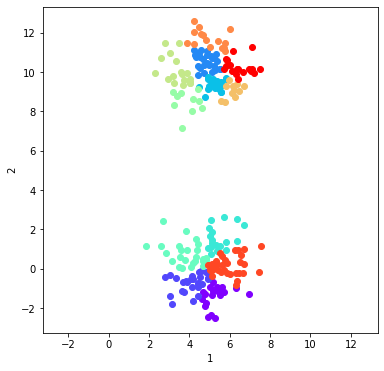

In [2]:
#Plot a single solution 
# We have to override default Scikit-learn settings, which have built in some determinism

c = oe.cluster(dataObj) #instantiate an openesembles clustering object
K = 12
name = 'kmeans'
c.cluster('parent', 'kmeans', name, K, init = 'random', n_init = 1) #This solution will be called 'kmeans'
plt_data = dataObj.plot_data('parent', class_labels=c.labels['kmeans']) #plot the data according to solution 'kmeans'
ymin, ymax = plt.ylim()
plt.xlim(ymin, ymax)
plt.show()

### Build the ensemble of many heuristic k-means solutions with large K

In [3]:
# Build an ensemble of Kmeans solutions and use Majority Voting as a finishing technique, calculating majority vote each time
# A solution is added. 
c = oe.cluster(dataObj) 
K = 12  # number of clusters to create
numIterations = 40
c_MV_arr = []
fig_arr = []
for i in range(1,numIterations):
    name = 'kmeans_' + str(i) #to append a new solution, it must have a name (dictionary key) that is unique
    c.cluster('parent', 'kmeans', name, K, init = 'random', n_init = 1) #c.cluster will eventually become numIterations long
    c_MV_arr.append(c.finish_majority_vote(threshold=0.5)) 


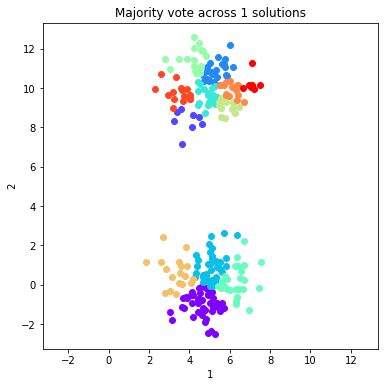

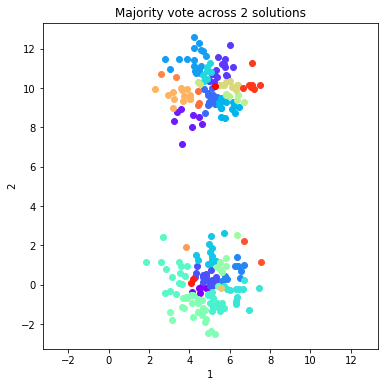

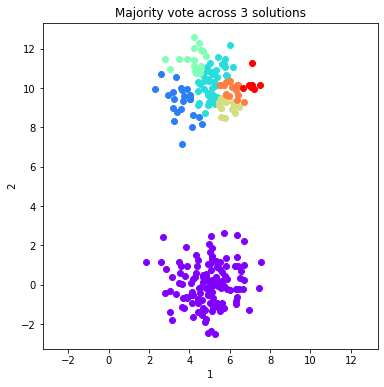

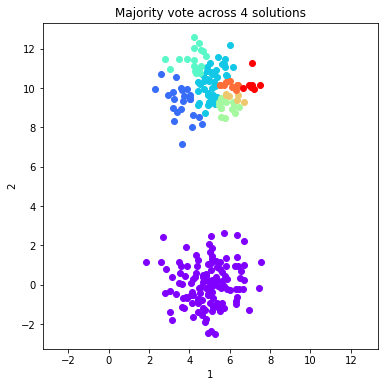

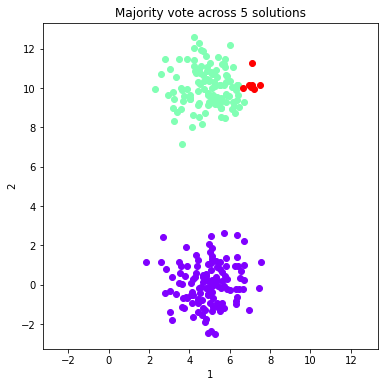

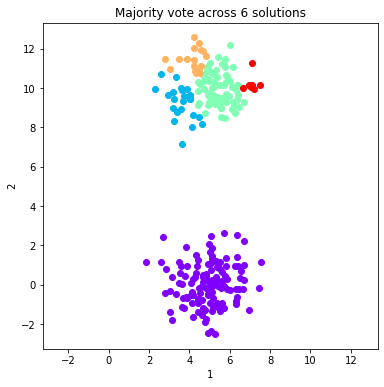

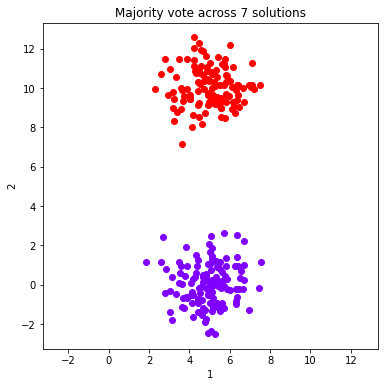

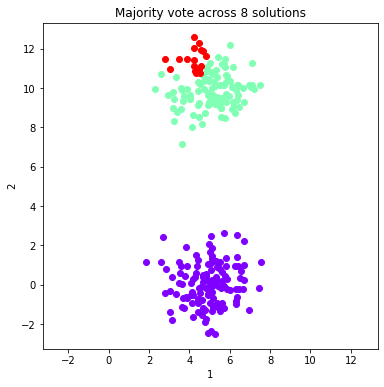

In [4]:
#Plot the majority vote solutions that are summed from 1:ind solutions (just the first 8)
for ind in range(0, 8, 1):

    fig = dataObj.plot_data('parent', class_labels=c_MV_arr[ind].labels['majority_vote'])
    plt.title('Majority vote across %d solutions'%(ind+1))
    ymin, ymax = plt.ylim()
    plt.xlim(ymin, ymax)
    plt.show()


### Calculate and plot two validation metrics across majority voting solutions

In [5]:
# Use the Silhouette score (measure of compactness) and Point Biserial (contiguousness)
sil_arr = []
det_arr = []


#Plot the majority vote solutions that are summed from 1:ind solutions (just the first 8)
for ind in range(0, len(c_MV_arr)):
        v = oe.validation(dataObj, c_MV_arr[ind]) #instantiate with the majority vote cluster object
    
        #A compactness metric
        validation_name = 'silhouette'
        output_name = v.calculate(validation_name, 'majority_vote', 'parent')
        sil_arr.append(v.validation[output_name])

        #A metric for contiguousness
        validation_name = 'point_biserial'
        output_name = v.calculate(validation_name, 'majority_vote', 'parent')
        det_arr.append(v.validation[output_name])
    


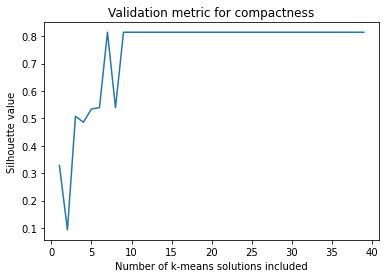

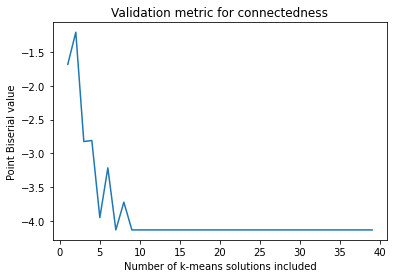

In [6]:
#Plot the two validation metrics as a function of index
x = list(range(1, len(c_MV_arr)+1))
plt.plot(x, sil_arr)
plt.title('Validation metric for compactness')
plt.xlabel('Number of k-means solutions included')
plt.ylabel('Silhouette value')
plt.show()

plt.plot(x, det_arr)
plt.title('Validation metric for connectedness')
plt.xlabel('Number of k-means solutions included')
plt.ylabel('Point Biserial value')
plt.show()

### Plot the co-occurrence matrix of the ensemble

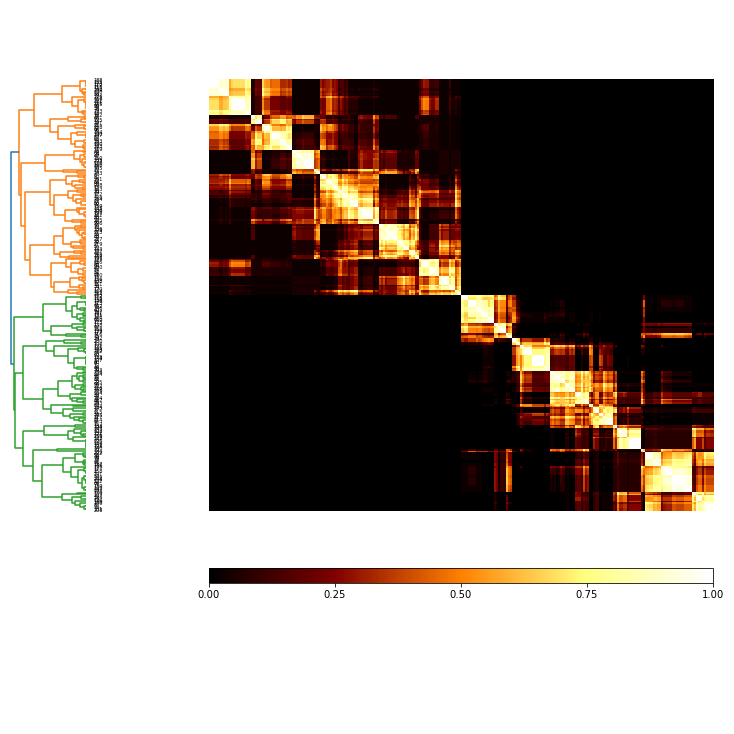

In [7]:
coMat = c.co_occurrence_matrix()
co_plot = coMat.plot(threshold=1, linkage='average', labels=False)
